# Notes 2 - Predictors of recorded DS live births

Next:

- Review data to see if we can go back further - check race
- Hyperparameter tuning
- Consider bagging vs GOSS


## Preparation


In [1]:
import joblib, optuna, os, shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from lightgbm import early_stopping, log_evaluation
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    brier_score_loss,
    log_loss,
)
from sklearn.model_selection import train_test_split

import repl_utils, stats_utils, data_utils, ml_utils, plot_utils
from variables import Variables as vars

pd.options.mode.copy_on_write = True

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = repl_utils.RANDOM_SEED
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)

N_CORES = joblib.cpu_count(only_physical_cores=True)

START_TIME = datetime.now()

OUTPUT_DIR = f"output/0002-predictors/{START_TIME:%Y%m%d-%H%M%S}"

os.makedirs(OUTPUT_DIR, exist_ok=True)

repl_utils.print_environment_info()

print(f"\n--------------------\nOutput directory: {OUTPUT_DIR}\n--------------------\n")

c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\arviz\__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


-------------------- Environment Information --------------------
date: 2025-12-23T10:19:17.059384
platform: Windows-11-10.0.26220-SP0
platform_version: 10.0.26220
cpu: Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
cores: 32
physical_cores: 24
ram: 127 GB
ram_available: 100 GB
cuda: True
cuda_device_count: 1
cuda_device_0: NVIDIA GeForce RTX 4070 Ti SUPER
python: 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:10:00) [MSC v.1944 64 bit (AMD64)]
numpy: 2.3.5
pandas: 2.3.3
scipy: 1.16.3
sklearn: 1.8.0
pytorch: 2.9.1
pymc: 5.27.0
pytensor: 2.36.1
arviz: 0.23.0

--------------------
Output directory: output/0002-predictors/20251223-101917
--------------------



### Options


In [2]:
START_YEAR = 2005
# LightGBM threads
NUM_THREADS = N_CORES - 2
# Splitting data for training, validation and calibration
TRAINING_SPLIT = 0.5
VALIDATION_SPLIT = 0.25
CALIBRATION_SPLIT = 1 - TRAINING_SPLIT - VALIDATION_SPLIT
#
NUM_BOOST_ROUND = 10000
EARLY_STOPPING_ROUNDS = 20
# True to search for hyperparameters
SELECT_HYPERPARAMETERS = True
#
OPTIMIZE_TRIALS = 50

SAVE_PLOTS = True

### Load data


In [3]:
df = data_utils.load_predictors_data(from_year=START_YEAR)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### Define initial feature set


In [4]:
numeric = [
    vars.YEAR,
    vars.DBWT,
    vars.PWGT_R,
    vars.WTGAIN,
    vars.BMI,
    vars.MAGE_C,
    vars.FAGECOMB,
]

categorical = [
    vars.DOB_MM,
    vars.DOB_WK,
    "dob_tt_pm",
    vars.BFACIL3,
    vars.SEX,
    vars.PRECARE,
    vars.GESTREC10,
    vars.RF_PDIAB,
    vars.RF_GDIAB,
    vars.RF_PHYPE,
    vars.RF_GHYPE,
    vars.RF_EHYPE,
    vars.RF_PPTERM,
    vars.RF_INFTR,
    vars.RF_FEDRG,
    vars.RF_ARTEC,
    vars.NO_RISKS,
    vars.LD_INDL,
    vars.LD_AUGM,
    vars.ME_PRES,
    vars.DMETH_REC,
    vars.APGAR5,
    vars.APGAR10,
    vars.AB_AVEN1,
    vars.AB_AVEN6,
    vars.AB_NICU,
    vars.AB_SURF,
    vars.AB_ANTI,
    vars.AB_SEIZ,
    vars.NO_ABNORM,
    vars.CA_ANEN,
    vars.CA_MNSB,
    vars.CA_CCHD,
    vars.CA_CDH,
    vars.CA_OMPH,
    vars.CA_GAST,
    vars.CA_LIMB,
    vars.CA_CLEFT,
    vars.CA_CLPAL,
    vars.CA_HYPO,
    vars.CA_DISOR,
    vars.NO_CONGEN,
    vars.MEDUC,
    vars.MRACEHISP,
    vars.FEDUC,
    vars.FRACEHISP,
    vars.PAY_REC,
    vars.WIC,
]

features = categorical + numeric

X = df[features]
y = df["ca_down_c_p_n"]

X[categorical] = X[categorical].astype("category")

### Split training, validation and calibration data


In [5]:
# use half the data for the training set
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=TRAINING_SPLIT, stratify=y, random_state=RANDOM_SEED
)

# use a quarter of the data for training validation and a quarter for calibration
X_valid, X_cal, y_valid, y_cal = train_test_split(
    X_tmp,
    y_tmp,
    test_size=(VALIDATION_SPLIT / TRAINING_SPLIT),
    stratify=y_tmp,
    random_state=RANDOM_SEED,
)

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

In [6]:
neg_count_train = y_train[y_train == 0].count()
pos_count_train = y_train[y_train == 1].count()
# scale_pos_weight = neg_count_train / pos_count_train

neg_count_valid = y_valid[y_valid == 0].count()
pos_count_valid = y_valid[y_valid == 1].count()

neg_count_cal = y_cal[y_cal == 0].count()
pos_count_cal = y_cal[y_cal == 1].count()

print(
    f"Training set: {neg_count_train} negatives, {pos_count_train} positives, probability positive {pos_count_train / neg_count_train:.8f}"
)
print(
    f"Validation set: {neg_count_valid} negatives, {pos_count_valid} positives, probability positive {pos_count_valid / neg_count_valid:.8f}"
)
print(
    f"Calibration set: {neg_count_cal} negatives, {pos_count_cal} positives, probability positive {pos_count_cal / neg_count_cal:.8f}"
)

Training set: 39061040 negatives, 19869 positives, probability positive 0.00050867
Validation set: 19530520 negatives, 9934 positives, probability positive 0.00050864
Calibration set: 19530521 negatives, 9934 positives, probability positive 0.00050864


In [ ]:
base_params = {
    "objective": "binary",
    "metric": ["average_precision", "binary_logloss"],
    "boosting_type": "gbdt",
    "max_bin": 255,  # GPU 63/127; CPU 255
    # for now, we do not scale for better interpretability of outputs
    "scale_pos_weight": 1,
    "force_col_wise": True,
    "seed": RANDOM_SEED,
    "num_threads": NUM_THREADS,
    "verbosity": 1,
}

last_best_params = {
    # "learning_rate": 0.014891637649695044,
    # "num_leaves": 81,
    # "min_data_in_leaf": 864,
    # "min_gain_to_split": 0.3567776136266129,
    # "feature_fraction": 0.610222833973872,
    # "bagging_fraction": 0.9226890884051586,
    # "bagging_freq": 6,
    # "lambda_l1": 0.00021596947276958148,
    # "lambda_l2": 8.98208844422193,
    
    "learning_rate": 0.012884501880074926,
    "num_leaves": 44,
    "min_data_in_leaf": 1403,
    "min_gain_to_split": 0.05655705189574356,
    "feature_fraction": 0.9643394215428954,
    "bagging_fraction": 0.9230892872686614,
    "bagging_freq": 3,
    "lambda_l1": 0.001172929804183367,
    "lambda_l2": 0.0003370399264102184,
}

## Hyperparameter tuning


In [8]:
def objective(trial):
    trial_params = {
        # required to change min_data_in_leaf across trials without rebuilding the Dataset
        "feature_pre_filter": False,
        # Speed / stability
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
        # Tree complexity
        "num_leaves": trial.suggest_int("num_leaves", 32, 512, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 500, 10000, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),
        # Sampling
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        # Regularization
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    }

    # Merge: base_params always present; trial_params override if same key exists
    params = {**base_params, **trial_params}

    pruning_cb = optuna.integration.LightGBMPruningCallback(trial, "average_precision")

    gbm = lgb.train(
        params,
        train_data,
        num_boost_round=NUM_BOOST_ROUND,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
            lgb.log_evaluation(period=10),
            pruning_cb,
        ],
    )

    # Best score on validation
    return gbm.best_score["valid_0"]["average_precision"]


if SELECT_HYPERPARAMETERS:
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.HyperbandPruner(),
    )

    study.optimize(objective, n_trials=OPTIMIZE_TRIALS)

    print(study.best_params, study.best_value)

    best = study.best_params
else:
    best = last_best_params

# Merge (best overrides base if there are collisions)
params = {**base_params, **best}
params["feature_pre_filter"] = True  # reset to default for final training

print("Parameters for training:")
for k, v in params.items():
    print(f'  "{k}": {v}')

[I 2025-12-23 10:21:35,491] A new study created in memory with name: no-name-737d6ffc-e27f-4e4e-ae5a-83fb1cedfdfe


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.377327	valid_0's binary_logloss: 0.00431566
[20]	valid_0's average_precision: 0.265378	valid_0's binary_logloss: 0.00641126


[I 2025-12-23 10:22:48,904] Trial 0 finished with value: 0.44244253837008474 and parameters: {'learning_rate': 0.04694211374463673, 'num_leaves': 78, 'min_data_in_leaf': 1475, 'min_gain_to_split': 0.6991346141848701, 'feature_fraction': 0.7207625968350538, 'bagging_fraction': 0.8222962122323493, 'bagging_freq': 4, 'lambda_l1': 0.009949305320793793, 'lambda_l2': 5.2326423451856115e-06}. Best is trial 0 with value: 0.44244253837008474.


Early stopping, best iteration is:
[6]	valid_0's average_precision: 0.442443	valid_0's binary_logloss: 0.00416103
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.293971	valid_0's binary_logloss: 0.00715973
[20]	valid_0's average_precision: 0.411271	valid_0's binary_logloss: 0.00416684
[30]	valid_0's average_precision: 0.459853	valid_0's binary_logloss: 0.00330819
[40]	valid_0's average_precision: 0.482105	valid_0's binary_logloss: 0.00301754
[50]	valid_0's average_precision: 0.48015	valid_0's binary_logloss: 0.00310614
[60]	valid_0's average_precision: 0.466582	valid_0's binary_logloss: 0.0035482
[70]	vali

[I 2025-12-23 10:25:22,205] Trial 1 finished with value: 0.492573803910414 and parameters: {'learning_rate': 0.0978606409762494, 'num_leaves': 268, 'min_data_in_leaf': 2651, 'min_gain_to_split': 0.6761055356997597, 'feature_fraction': 0.7880522815137095, 'bagging_fraction': 0.6475313698923958, 'bagging_freq': 1, 'lambda_l1': 5.000820191982064e-06, 'lambda_l2': 0.0009692498090671928}. Best is trial 1 with value: 0.492573803910414.


Early stopping, best iteration is:
[58]	valid_0's average_precision: 0.492574	valid_0's binary_logloss: 0.00285229
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.48628	valid_0's binary_logloss: 0.00327342
[20]	valid_0's average_precision: 0.522634	valid_0's binary_logloss: 0.00250288
[30]	valid_0's average_precision: 0.530255	valid_0's binary_logloss: 0.0023066
[40]	valid_0's average_precision: 0.535329	valid_0's binary_logloss: 0.00218651
[50]	valid_0's average_precision: 0.539783	valid_0's binary_logloss: 0.00209502
[60]	valid_0's average_precision: 0.542795	valid_0's binary_logloss: 0.00203271
[70]	val

[I 2025-12-23 10:32:39,663] Trial 2 finished with value: 0.5523189586058075 and parameters: {'learning_rate': 0.03013475008660771, 'num_leaves': 228, 'min_data_in_leaf': 3073, 'min_gain_to_split': 0.6552029695537757, 'feature_fraction': 0.9536860936471747, 'bagging_fraction': 0.9899279456607059, 'bagging_freq': 8, 'lambda_l1': 2.011768791223388e-08, 'lambda_l2': 3.530443581940399e-06}. Best is trial 2 with value: 0.5523189586058075.


Early stopping, best iteration is:
[181]	valid_0's average_precision: 0.552319	valid_0's binary_logloss: 0.0019038
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.508173	valid_0's binary_logloss: 0.00319176
[20]	valid_0's average_precision: 0.527423	valid_0's binary_logloss: 0.00268313
[30]	valid_0's average_precision: 0.538084	valid_0's binary_logloss: 0.00234798
[40]	valid_0's average_precision: 0.542935	valid_0's binary_logloss: 0.00214734
[50]	valid_0's average_precision: 0.545626	valid_0's binary_logloss: 0.00205735
[60]	valid_0's average_precision: 0.547392	valid_0's binary_logloss: 0.00200918
[70]	v

[I 2025-12-23 10:38:38,627] Trial 3 finished with value: 0.5500068521046152 and parameters: {'learning_rate': 0.045071182666537736, 'num_leaves': 393, 'min_data_in_leaf': 2493, 'min_gain_to_split': 0.18659860023378727, 'feature_fraction': 0.890078666914961, 'bagging_fraction': 0.90028932672633, 'bagging_freq': 5, 'lambda_l1': 8.534813046547867e-07, 'lambda_l2': 1.552798176937815e-07}. Best is trial 2 with value: 0.5523189586058075.


[160]	valid_0's average_precision: 0.541089	valid_0's binary_logloss: 0.00197529
Early stopping, best iteration is:
[140]	valid_0's average_precision: 0.550007	valid_0's binary_logloss: 0.00195125
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 10:38:43,411] Trial 4 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 10:38:51,549] Trial 5 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 10:38:57,422] Trial 6 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 10:39:03,129] Trial 7 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 10:39:22,678] Trial 8 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 10:39:28,490] Trial 9 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 10:39:38,171] Trial 10 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 10:39:44,036] Trial 11 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 10:40:03,789] Trial 12 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 10:40:12,180] Trial 13 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.543596	valid_0's binary_logloss: 0.00234272
[20]	valid_0's average_precision: 0.542907	valid_0's binary_logloss: 0.00208812


[I 2025-12-23 10:41:00,983] Trial 14 finished with value: 0.5436867085126833 and parameters: {'learning_rate': 0.053905521875541686, 'num_leaves': 119, 'min_data_in_leaf': 893, 'min_gain_to_split': 0.566441387077623, 'feature_fraction': 0.9174852452230364, 'bagging_fraction': 0.8448336403689009, 'bagging_freq': 7, 'lambda_l1': 1.0548997709637387e-08, 'lambda_l2': 3.5211511081255e-07}. Best is trial 2 with value: 0.5523189586058075.


Early stopping, best iteration is:
[8]	valid_0's average_precision: 0.543687	valid_0's binary_logloss: 0.00242728
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 10:41:10,225] Trial 15 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 10:41:15,626] Trial 16 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 10:41:20,615] Trial 17 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 10:41:26,241] Trial 18 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.545547	valid_0's binary_logloss: 0.00223496
[20]	valid_0's average_precision: 0.546407	valid_0's binary_logloss: 0.00207088
[30]	valid_0's average_precision: 0.546803	valid_0's binary_logloss: 0.00198389
[40]	valid_0's average_precision: 0.547138	valid_0's binary_logloss: 0.00193478
[50]	valid_0's average_precision: 0.547342	valid_0's binary_logloss: 0.00190326
[60]	valid_0's average_precision: 0.547625	valid_0's binary_logloss: 0.00188297
[70]	valid_0's average_precision: 0.54796	valid_0's binary_logloss: 0.00187027
[80]	valid_0's average_precision: 0.548109

[I 2025-12-23 10:46:07,946] Trial 19 finished with value: 0.5489872338382271 and parameters: {'learning_rate': 0.04067090234069097, 'num_leaves': 108, 'min_data_in_leaf': 828, 'min_gain_to_split': 0.1716574489439459, 'feature_fraction': 0.86970932460432, 'bagging_fraction': 0.9046182781269502, 'bagging_freq': 8, 'lambda_l1': 0.00033119932822006637, 'lambda_l2': 9.300207197491787e-08}. Best is trial 2 with value: 0.5523189586058075.


Early stopping, best iteration is:
[132]	valid_0's average_precision: 0.548987	valid_0's binary_logloss: 0.00184588
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 10:46:13,452] Trial 20 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.545037	valid_0's binary_logloss: 0.00220309
[20]	valid_0's average_precision: 0.546967	valid_0's binary_logloss: 0.00206028
[30]	valid_0's average_precision: 0.547691	valid_0's binary_logloss: 0.00198277
[40]	valid_0's average_precision: 0.547849	valid_0's binary_logloss: 0.00193573
[50]	valid_0's average_precision: 0.548164	valid_0's binary_logloss: 0.00190402
[60]	valid_0's average_precision: 0.54838	valid_0's binary_logloss: 0.00188363
[70]	valid_0's average_precision: 0.548679	valid_0's binary_logloss: 0.00186964
[80]	valid_0's average_precision: 0.548894

[I 2025-12-23 10:53:04,448] Trial 21 finished with value: 0.5506190153534044 and parameters: {'learning_rate': 0.0375958255159286, 'num_leaves': 121, 'min_data_in_leaf': 1205, 'min_gain_to_split': 0.1387109075809294, 'feature_fraction': 0.8743302501417874, 'bagging_fraction': 0.9144544334085952, 'bagging_freq': 8, 'lambda_l1': 0.0018710105842128922, 'lambda_l2': 8.514828012211875e-08}. Best is trial 2 with value: 0.5523189586058075.


Early stopping, best iteration is:
[201]	valid_0's average_precision: 0.550619	valid_0's binary_logloss: 0.00183737
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.535324	valid_0's binary_logloss: 0.00248795
[20]	valid_0's average_precision: 0.539569	valid_0's binary_logloss: 0.00233317
[30]	valid_0's average_precision: 0.54169	valid_0's binary_logloss: 0.00222304
[40]	valid_0's average_precision: 0.542629	valid_0's binary_logloss: 0.0021572
[50]	valid_0's average_precision: 0.543476	valid_0's binary_logloss: 0.00210883
[60]	valid_0's average_precision: 0.544412	valid_0's binary_logloss: 0.00207091
[70]	va

[I 2025-12-23 10:55:23,814] Trial 22 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 10:55:42,290] Trial 23 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 10:55:49,372] Trial 24 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 10:55:54,284] Trial 25 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 10:56:12,841] Trial 26 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-23 10:56:20,952] Trial 27 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 10:56:30,025] Trial 28 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 10:56:51,099] Trial 29 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.546599	valid_0's binary_logloss: 0.00217557
[20]	valid_0's average_precision: 0.547786	valid_0's binary_logloss: 0.00207239
[30]	valid_0's average_precision: 0.548669	valid_0's binary_logloss: 0.00200607
[40]	valid_0's average_precision: 0.549287	valid_0's binary_logloss: 0.00196034
[50]	valid_0's average_precision: 0.549832	valid_0's binary_logloss: 0.00192785
[60]	valid_0's average_precision: 0.550302	valid_0's binary_logloss: 0.00190372
[70]	valid_0's average_precision: 0.550564	valid_0's binary_logloss: 0.00188664
[80]	valid_0's average_precision: 0.55083

[I 2025-12-23 11:05:44,315] Trial 30 finished with value: 0.5525869407569846 and parameters: {'learning_rate': 0.02848008135800706, 'num_leaves': 60, 'min_data_in_leaf': 1344, 'min_gain_to_split': 0.12028570174156274, 'feature_fraction': 0.9265296874641816, 'bagging_fraction': 0.9775849755613362, 'bagging_freq': 4, 'lambda_l1': 0.005948453361065357, 'lambda_l2': 1.0563409353921103e-06}. Best is trial 30 with value: 0.5525869407569846.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.546421	valid_0's binary_logloss: 0.0021784
[20]	valid_0's average_precision: 0.547322	valid_0's binary_logloss: 0.00207474
[30]	valid_0's average_precision: 0.547986	valid_0's binary_logloss: 0.00200836
[40]	valid_0's average_precision: 0.548638	valid_0's binary_logloss: 0.0019622
[50]	valid_0's average_precision: 0.549189	valid_0's binary_logloss: 0.00192931
[60]	valid_0's average_precision: 0.549634	valid_0's binary_logloss: 0.00190566
[70]	valid_0's average_precision: 0.549991	valid_0's binary_logloss: 0.00188825
[80]	valid_0's average_precision: 0.550262	

[I 2025-12-23 11:15:14,241] Trial 31 finished with value: 0.5525218279915088 and parameters: {'learning_rate': 0.029254006190157743, 'num_leaves': 49, 'min_data_in_leaf': 1356, 'min_gain_to_split': 0.11870412641590107, 'feature_fraction': 0.9237551438252032, 'bagging_fraction': 0.9675079893784385, 'bagging_freq': 4, 'lambda_l1': 0.011683660717490323, 'lambda_l2': 1.0539540607378366e-06}. Best is trial 30 with value: 0.5525869407569846.


Early stopping, best iteration is:
[287]	valid_0's average_precision: 0.552522	valid_0's binary_logloss: 0.00183032
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.546586	valid_0's binary_logloss: 0.00218096
[20]	valid_0's average_precision: 0.547927	valid_0's binary_logloss: 0.00207987
[30]	valid_0's average_precision: 0.548899	valid_0's binary_logloss: 0.00201411
[40]	valid_0's average_precision: 0.549561	valid_0's binary_logloss: 0.00196814
[50]	valid_0's average_precision: 0.550129	valid_0's binary_logloss: 0.0019347
[60]	valid_0's average_precision: 0.550516	valid_0's binary_logloss: 0.00191026
[70]	v

[I 2025-12-23 11:23:10,613] Trial 32 finished with value: 0.5526113919718839 and parameters: {'learning_rate': 0.026721648945064284, 'num_leaves': 57, 'min_data_in_leaf': 1314, 'min_gain_to_split': 0.127367460221414, 'feature_fraction': 0.9405162799194879, 'bagging_fraction': 0.9733751857804639, 'bagging_freq': 3, 'lambda_l1': 0.011531160687448187, 'lambda_l2': 1.120614416503129e-06}. Best is trial 32 with value: 0.5526113919718839.


Early stopping, best iteration is:
[233]	valid_0's average_precision: 0.552611	valid_0's binary_logloss: 0.00182957
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.54706	valid_0's binary_logloss: 0.00219009
[20]	valid_0's average_precision: 0.548318	valid_0's binary_logloss: 0.00209079
[30]	valid_0's average_precision: 0.549263	valid_0's binary_logloss: 0.00202544
[40]	valid_0's average_precision: 0.549891	valid_0's binary_logloss: 0.00197897
[50]	valid_0's average_precision: 0.550288	valid_0's binary_logloss: 0.00194507
[60]	valid_0's average_precision: 0.550572	valid_0's binary_logloss: 0.00191944
[70]	v

[I 2025-12-23 11:32:55,207] Trial 33 finished with value: 0.5532323169432838 and parameters: {'learning_rate': 0.02456318886661645, 'num_leaves': 59, 'min_data_in_leaf': 1564, 'min_gain_to_split': 0.0865605376298895, 'feature_fraction': 0.9300497436069466, 'bagging_fraction': 0.9753272182903823, 'bagging_freq': 4, 'lambda_l1': 0.017798613291539974, 'lambda_l2': 8.936880449567301e-07}. Best is trial 33 with value: 0.5532323169432838.


Early stopping, best iteration is:
[291]	valid_0's average_precision: 0.553232	valid_0's binary_logloss: 0.00182651
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.547705	valid_0's binary_logloss: 0.00220592
[20]	valid_0's average_precision: 0.549629	valid_0's binary_logloss: 0.00210666
[30]	valid_0's average_precision: 0.550526	valid_0's binary_logloss: 0.00204073
[40]	valid_0's average_precision: 0.551029	valid_0's binary_logloss: 0.00199329
[50]	valid_0's average_precision: 0.55142	valid_0's binary_logloss: 0.00195796
[60]	valid_0's average_precision: 0.551672	valid_0's binary_logloss: 0.00193058
[70]	v

[I 2025-12-23 11:42:38,086] Trial 34 finished with value: 0.5542299889067114 and parameters: {'learning_rate': 0.021927670236097742, 'num_leaves': 52, 'min_data_in_leaf': 1360, 'min_gain_to_split': 0.0041023273093089285, 'feature_fraction': 0.9263182281270548, 'bagging_fraction': 0.9689101254975362, 'bagging_freq': 4, 'lambda_l1': 0.01562686822697257, 'lambda_l2': 0.0029654179403733882}. Best is trial 34 with value: 0.5542299889067114.


Early stopping, best iteration is:
[292]	valid_0's average_precision: 0.55423	valid_0's binary_logloss: 0.00182346
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.546247	valid_0's binary_logloss: 0.00221412
[20]	valid_0's average_precision: 0.547398	valid_0's binary_logloss: 0.00211641
[30]	valid_0's average_precision: 0.548058	valid_0's binary_logloss: 0.00205099
[40]	valid_0's average_precision: 0.548406	valid_0's binary_logloss: 0.00200305
[50]	valid_0's average_precision: 0.548859	valid_0's binary_logloss: 0.00196704
[60]	valid_0's average_precision: 0.549194	valid_0's binary_logloss: 0.00193929
[70]	v

[I 2025-12-23 11:50:36,320] Trial 35 finished with value: 0.5516503924785845 and parameters: {'learning_rate': 0.021534378722861857, 'num_leaves': 61, 'min_data_in_leaf': 1005, 'min_gain_to_split': 0.06866319030456408, 'feature_fraction': 0.9720348032049773, 'bagging_fraction': 0.6794190671698626, 'bagging_freq': 3, 'lambda_l1': 0.02335820698903949, 'lambda_l2': 0.006475809914053601}. Best is trial 34 with value: 0.5542299889067114.


Early stopping, best iteration is:
[276]	valid_0's average_precision: 0.55165	valid_0's binary_logloss: 0.00183148
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.549065	valid_0's binary_logloss: 0.00226062
[20]	valid_0's average_precision: 0.550372	valid_0's binary_logloss: 0.00216833
[30]	valid_0's average_precision: 0.551084	valid_0's binary_logloss: 0.00210431
[40]	valid_0's average_precision: 0.551499	valid_0's binary_logloss: 0.00205659
[50]	valid_0's average_precision: 0.551768	valid_0's binary_logloss: 0.00201877
[60]	valid_0's average_precision: 0.55202	valid_0's binary_logloss: 0.00198776
[70]	va

[I 2025-12-23 12:09:03,549] Trial 36 finished with value: 0.5551825450124561 and parameters: {'learning_rate': 0.014648199983259776, 'num_leaves': 68, 'min_data_in_leaf': 718, 'min_gain_to_split': 0.007980962498167099, 'feature_fraction': 0.9404290975743179, 'bagging_fraction': 0.9747567911157792, 'bagging_freq': 4, 'lambda_l1': 0.7434146820483761, 'lambda_l2': 0.0018007292425234497}. Best is trial 36 with value: 0.5551825450124561.


Early stopping, best iteration is:
[562]	valid_0's average_precision: 0.555183	valid_0's binary_logloss: 0.00181844
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 12:09:19,682] Trial 37 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.547517	valid_0's binary_logloss: 0.0022501
[20]	valid_0's average_precision: 0.548551	valid_0's binary_logloss: 0.00215748


[I 2025-12-23 12:10:01,517] Trial 38 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 12:10:05,678] Trial 39 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 12:10:21,675] Trial 40 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.547408	valid_0's binary_logloss: 0.00218752
[20]	valid_0's average_precision: 0.548107	valid_0's binary_logloss: 0.00208516
[30]	valid_0's average_precision: 0.548213	valid_0's binary_logloss: 0.00201924
[40]	valid_0's average_precision: 0.548458	valid_0's binary_logloss: 0.00197289
[50]	valid_0's average_precision: 0.548794	valid_0's binary_logloss: 0.00193912
[60]	valid_0's average_precision: 0.549048	valid_0's binary_logloss: 0.00191469
[70]	valid_0's average_precision: 0.549325	valid_0's binary_logloss: 0.00189576
[80]	valid_0's average_precision: 0.54947

[I 2025-12-23 12:12:44,177] Trial 41 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 12:12:51,454] Trial 42 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.550299	valid_0's binary_logloss: 0.00227846
[20]	valid_0's average_precision: 0.551781	valid_0's binary_logloss: 0.00218889
[30]	valid_0's average_precision: 0.552468	valid_0's binary_logloss: 0.0021258
[40]	valid_0's average_precision: 0.552992	valid_0's binary_logloss: 0.00207764
[50]	valid_0's average_precision: 0.553314	valid_0's binary_logloss: 0.0020399
[60]	valid_0's average_precision: 0.553473	valid_0's binary_logloss: 0.00200858
[70]	valid_0's average_precision: 0.553671	valid_0's binary_logloss: 0.00198286
[80]	valid_0's average_precision: 0.55388	v

[I 2025-12-23 12:28:21,007] Trial 43 finished with value: 0.5568324880097034 and parameters: {'learning_rate': 0.012884501880074926, 'num_leaves': 44, 'min_data_in_leaf': 1403, 'min_gain_to_split': 0.05655705189574356, 'feature_fraction': 0.9643394215428954, 'bagging_fraction': 0.9230892872686614, 'bagging_freq': 3, 'lambda_l1': 0.001172929804183367, 'lambda_l2': 0.0003370399264102184}. Best is trial 43 with value: 0.5568324880097034.


Early stopping, best iteration is:
[497]	valid_0's average_precision: 0.556832	valid_0's binary_logloss: 0.00181583
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 12:28:25,309] Trial 44 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 12:28:29,621] Trial 45 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds


[I 2025-12-23 12:28:34,207] Trial 46 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.550167	valid_0's binary_logloss: 0.00231133
[20]	valid_0's average_precision: 0.551645	valid_0's binary_logloss: 0.00222673
[30]	valid_0's average_precision: 0.552393	valid_0's binary_logloss: 0.00216896
[40]	valid_0's average_precision: 0.552906	valid_0's binary_logloss: 0.00212336
[50]	valid_0's average_precision: 0.553234	valid_0's binary_logloss: 0.00208626
[60]	valid_0's average_precision: 0.553487	valid_0's binary_logloss: 0.00205507
[70]	valid_0's average_precision: 0.553664	valid_0's binary_logloss: 0.00202861
[80]	valid_0's average_precision: 0.55380

[I 2025-12-23 12:47:05,594] Trial 47 finished with value: 0.5564927000768622 and parameters: {'learning_rate': 0.01002556709269923, 'num_leaves': 41, 'min_data_in_leaf': 1098, 'min_gain_to_split': 0.14678854664966873, 'feature_fraction': 0.8912198899538993, 'bagging_fraction': 0.9806714239262814, 'bagging_freq': 5, 'lambda_l1': 0.0001072367962831412, 'lambda_l2': 6.541905905026335e-05}. Best is trial 43 with value: 0.5568324880097034.


Early stopping, best iteration is:
[595]	valid_0's average_precision: 0.556493	valid_0's binary_logloss: 0.00181727
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.549432	valid_0's binary_logloss: 0.00226033
[20]	valid_0's average_precision: 0.55084	valid_0's binary_logloss: 0.00216674
[30]	valid_0's average_precision: 0.551713	valid_0's binary_logloss: 0.00210318
[40]	valid_0's average_precision: 0.552191	valid_0's binary_logloss: 0.0020547
[50]	valid_0's average_precision: 0.552544	valid_0's binary_logloss: 0.00201669
[60]	valid_0's average_precision: 0.552699	valid_0's binary_logloss: 0.00198613
[70]	va

[I 2025-12-23 12:59:25,407] Trial 48 finished with value: 0.5550907393749448 and parameters: {'learning_rate': 0.015113093193433885, 'num_leaves': 47, 'min_data_in_leaf': 792, 'min_gain_to_split': 0.3060442388451298, 'feature_fraction': 0.8919872249789131, 'bagging_fraction': 0.8881283295680517, 'bagging_freq': 5, 'lambda_l1': 3.428787947363459e-05, 'lambda_l2': 0.0006532444308276958}. Best is trial 43 with value: 0.5568324880097034.


[410]	valid_0's average_precision: 0.555086	valid_0's binary_logloss: 0.00182114
Early stopping, best iteration is:
[390]	valid_0's average_precision: 0.555091	valid_0's binary_logloss: 0.00182143
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.549271	valid_0's binary_logloss: 0.00230992
[20]	valid_0's average_precision: 0.550401	valid_0's binary_logloss: 0.00222519
[30]	valid_0's average_precision: 0.551179	valid_0's binary_logloss: 0.00216669
[40]	valid_0's average_precision: 0.551599	valid_0's binary_logloss: 0.00212085
[50]	valid_0's average_precision: 0.551924	valid_0's binary_logloss: 0.00208346
[60]

[I 2025-12-23 13:16:43,432] Trial 49 finished with value: 0.5552534985452379 and parameters: {'learning_rate': 0.010400316804431145, 'num_leaves': 37, 'min_data_in_leaf': 620, 'min_gain_to_split': 0.3021312139684618, 'feature_fraction': 0.8938552879667988, 'bagging_fraction': 0.8946971433583094, 'bagging_freq': 5, 'lambda_l1': 9.394562202195643e-05, 'lambda_l2': 0.017633345216249263}. Best is trial 43 with value: 0.5568324880097034.


[600]	valid_0's average_precision: 0.555249	valid_0's binary_logloss: 0.00181966
Early stopping, best iteration is:
[580]	valid_0's average_precision: 0.555253	valid_0's binary_logloss: 0.00181998
{'learning_rate': 0.012884501880074926, 'num_leaves': 44, 'min_data_in_leaf': 1403, 'min_gain_to_split': 0.05655705189574356, 'feature_fraction': 0.9643394215428954, 'bagging_fraction': 0.9230892872686614, 'bagging_freq': 3, 'lambda_l1': 0.001172929804183367, 'lambda_l2': 0.0003370399264102184} 0.5568324880097034
Parameters for training:
  "objective": binary
  "metric": ['average_precision', 'binary_logloss']
  "boosting_type": gbdt
  "max_bin": 255
  "scale_pos_weight": 1
  "force_col_wise": True
  "seed": 202512
  "num_threads": 22
  "verbosity": 1
  "learning_rate": 0.012884501880074926
  "num_leaves": 44
  "min_data_in_leaf": 1403
  "min_gain_to_split": 0.05655705189574356
  "feature_fraction": 0.9643394215428954
  "bagging_fraction": 0.9230892872686614
  "bagging_freq": 3
  "lambda_l1":

## Model 0 (all initial predictors)


In [9]:
model_idx = 0
model_name = f"Model {model_idx} (all initial predictors)"

gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 20 rounds
[10]	train's average_precision: 0.554764	train's binary_logloss: 0.00226497	valid's average_precision: 0.550299	valid's binary_logloss: 0.00227846
[20]	train's average_precision: 0.556875	train's binary_logloss: 0.00217344	valid's average_precision: 0.551781	valid's binary_logloss: 0.00218889
[30]	train's average_precision: 0.557937	train's binary_logloss: 0.00210919	valid's average_precision: 0.552468	valid's binary_logloss: 0.0021258
[40]	train's average_precision: 0.558786	train's binary_logloss: 0.00205973	valid's average_precision: 0.552992	valid's binary_logloss: 0.00207764
[50]	train's a

In [10]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [11]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.967297
1,Validation AP,0.556832
2,Validation log loss,0.001816
3,Precision at 10000,0.529800
4,Recall at 10000,0.533320
5,Precision (threshold=0.01),0.136945
6,Recall (threshold=0.01),0.626938


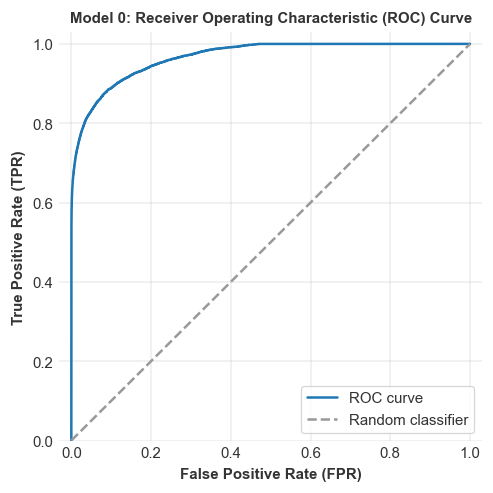

In [12]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

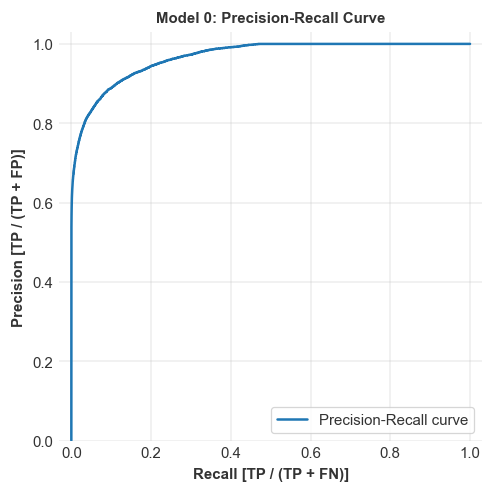

In [13]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

#### Feature importance


In [14]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
41,no_congen,3.671363e+06
34,ca_omph,2.454795e+06
30,ca_anen,2.092792e+06
36,ca_limb,1.813684e+06
33,ca_cdh,1.421670e+06
31,ca_mnsb,1.222766e+06
38,ca_clpal,1.200197e+06
35,ca_gast,1.038326e+06
32,ca_cchd,9.925571e+05
40,ca_disor,8.872021e+05


### Evaluation subset for permutation importances and SHAP analysis


In [15]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

In [16]:
model_wrapped = ml_utils.LGBMEstimator(gbm)

In [17]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
41,no_congen,0.522336,0.000595
32,ca_cchd,0.232874,0.001557
40,ca_disor,0.192661,0.002320
37,ca_cleft,0.158198,0.002087
39,ca_hypo,0.136617,0.002239
38,ca_clpal,0.131818,0.002043
33,ca_cdh,0.120565,0.002303
31,ca_mnsb,0.115480,0.002391
34,ca_omph,0.114114,0.001672
36,ca_limb,0.100539,0.002298


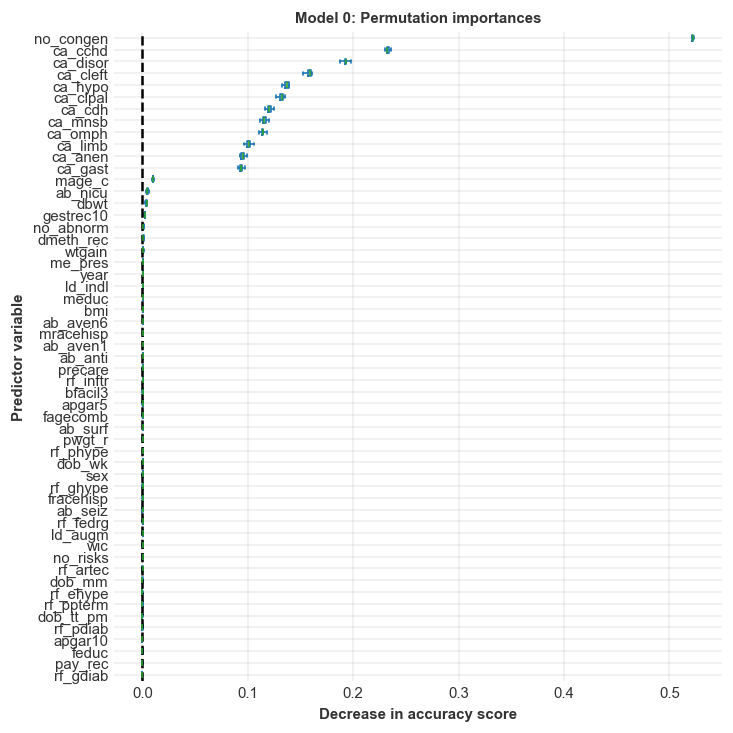

In [18]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

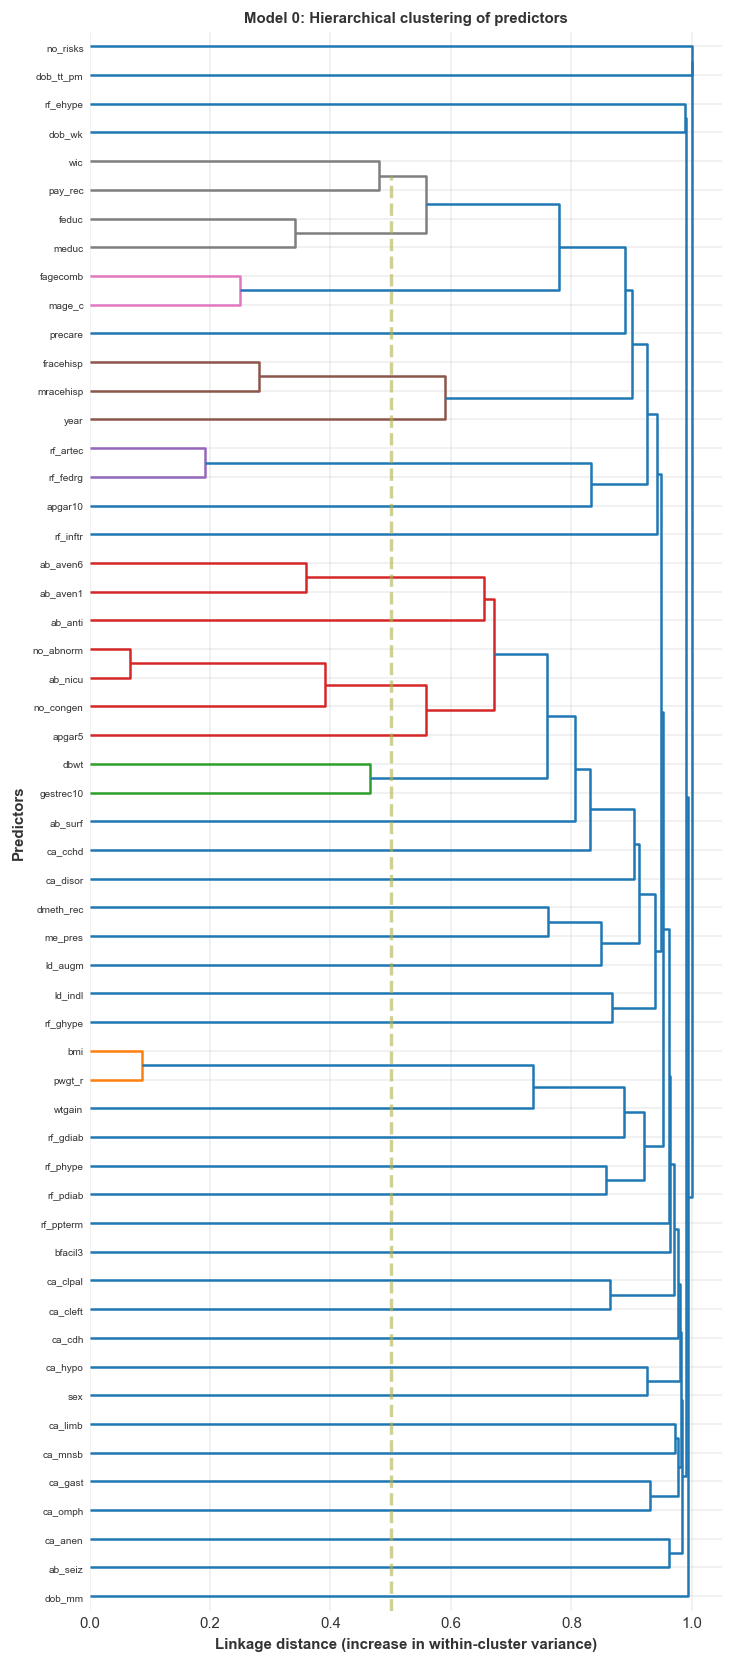

In [19]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

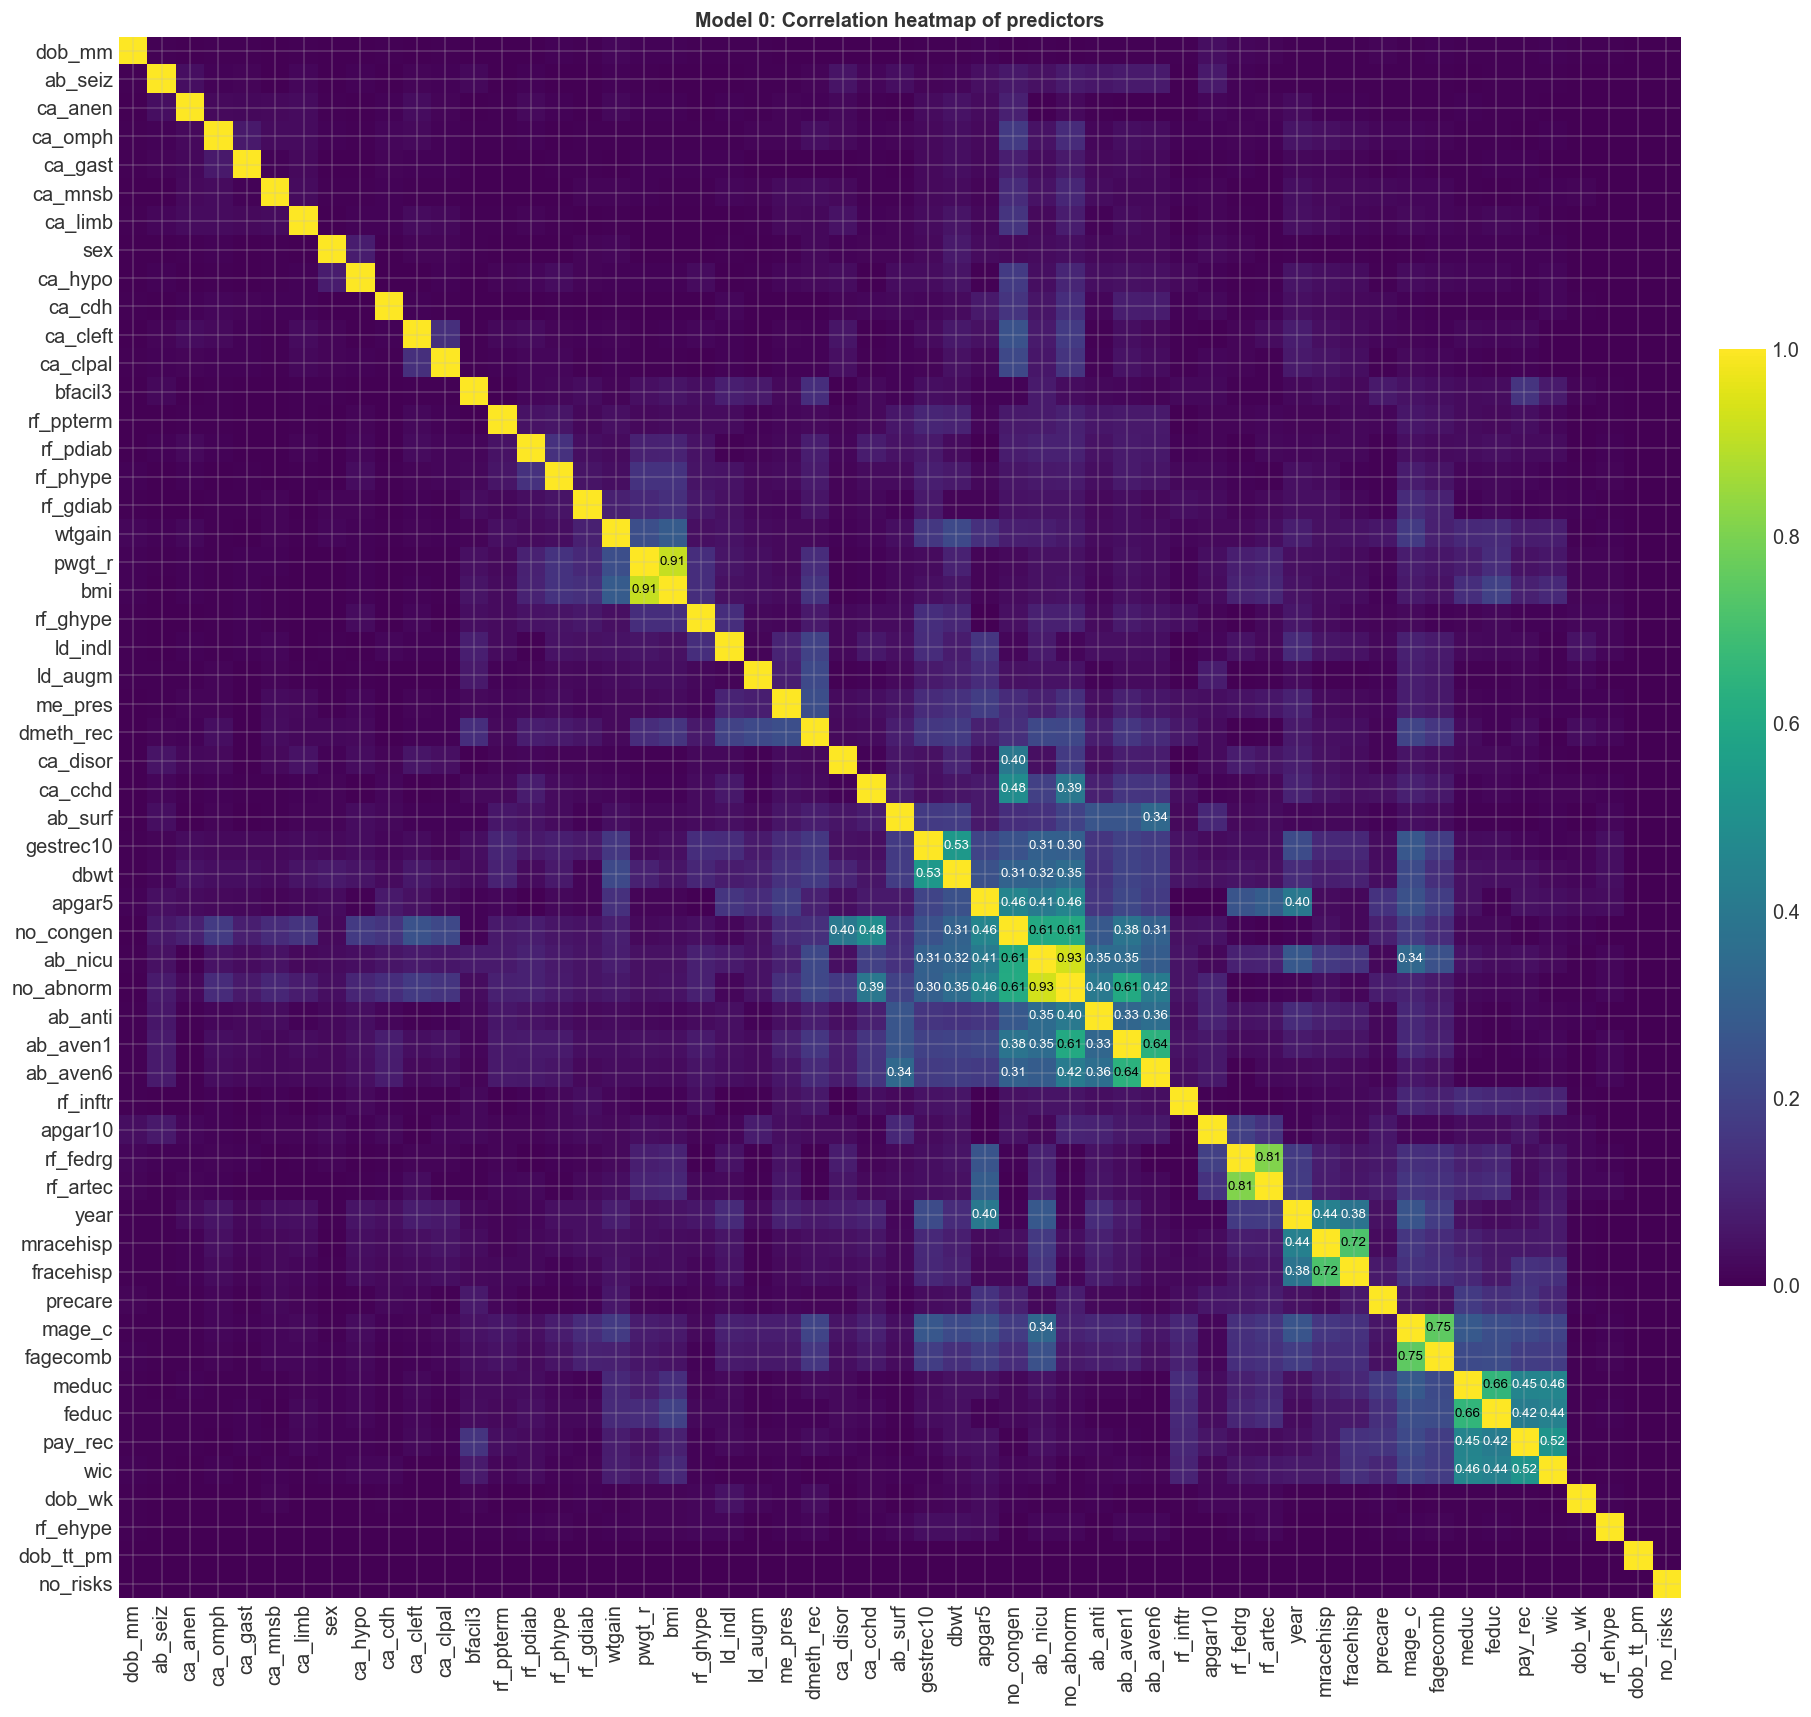

In [20]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [21]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\

,feature,mean_abs_shap
41,no_congen,3.893216
53,mage_c,0.549926
25,ab_nicu,0.519246
49,dbwt,0.247484
32,ca_cchd,0.220981
40,ca_disor,0.186537
6,gestrec10,0.161033
37,ca_cleft,0.103537
38,ca_clpal,0.087875
34,ca_omph,0.084101


In [22]:
shap_importance["feature"].tolist()

['no_congen',
 'mage_c',
 'ab_nicu',
 'dbwt',
 'ca_cchd',
 'ca_disor',
 'gestrec10',
 'ca_cleft',
 'ca_clpal',
 'ca_omph',
 'mracehisp',
 'ca_hypo',
 'ca_limb',
 'wtgain',
 'ca_cdh',
 'ab_aven1',
 'ca_gast',
 'ca_mnsb',
 'no_abnorm',
 'ab_anti',
 'ca_anen',
 'precare',
 'fagecomb',
 'dmeth_rec',
 'bfacil3',
 'fracehisp',
 'ab_aven6',
 'meduc',
 'pwgt_r',
 'apgar5',
 'dob_wk',
 'ld_indl',
 'year',
 'me_pres',
 'dob_mm',
 'bmi',
 'rf_ghype',
 'rf_gdiab',
 'ab_seiz',
 'feduc',
 'rf_phype',
 'sex',
 'rf_pdiab',
 'ab_surf',
 'ld_augm',
 'rf_ehype',
 'rf_inftr',
 'pay_rec',
 'no_risks',
 'rf_artec',
 'rf_fedrg',
 'dob_tt_pm',
 'rf_ppterm',
 'wic',
 'apgar10']

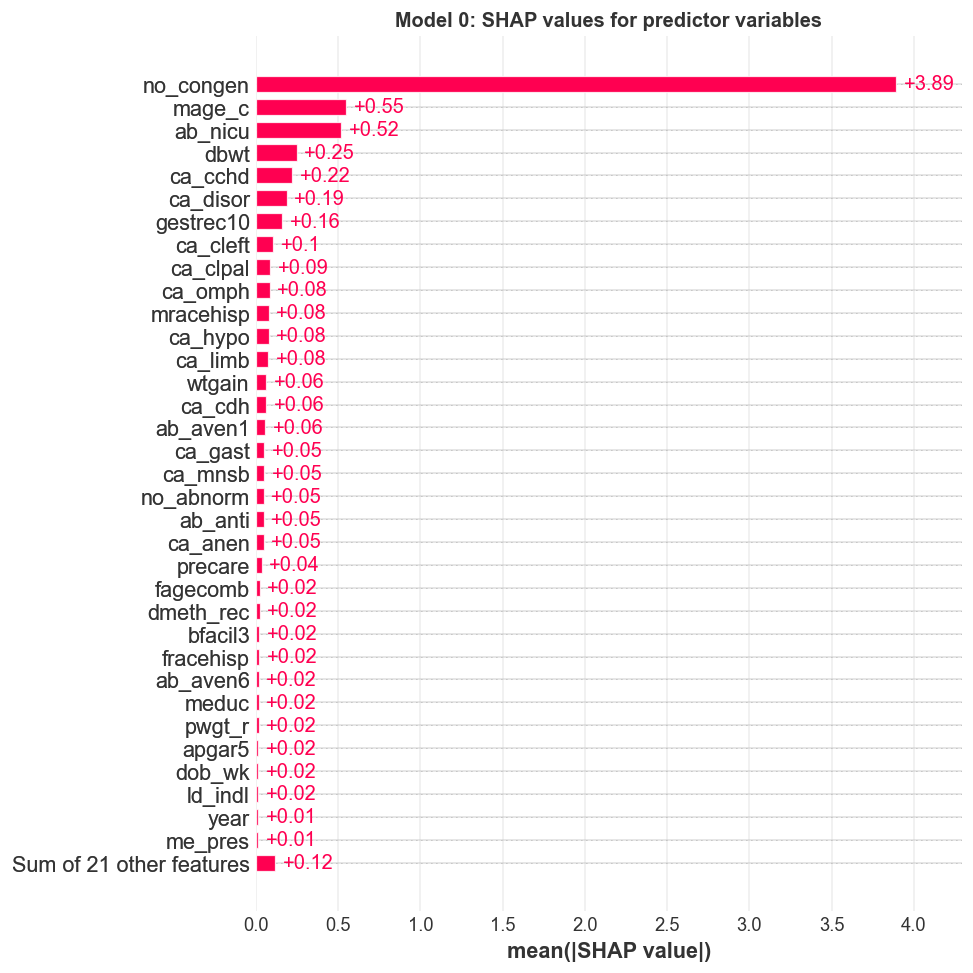

<Figure size 492x348 with 0 Axes>

In [23]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

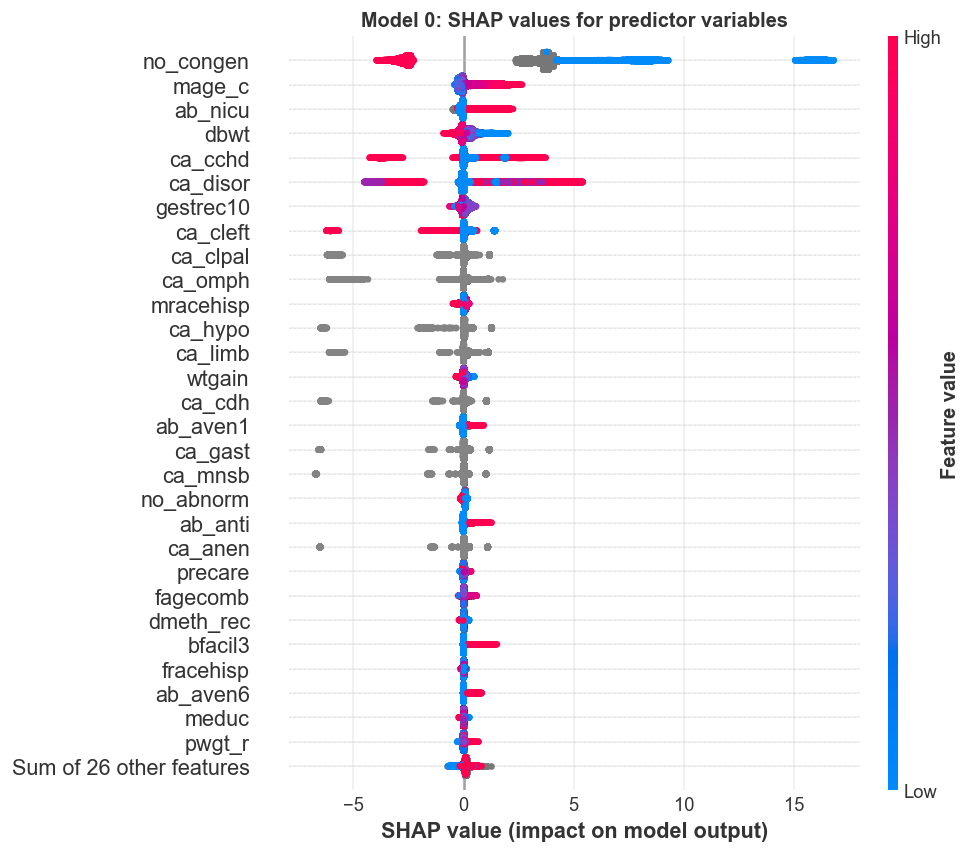

<Figure size 492x348 with 0 Axes>

In [24]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

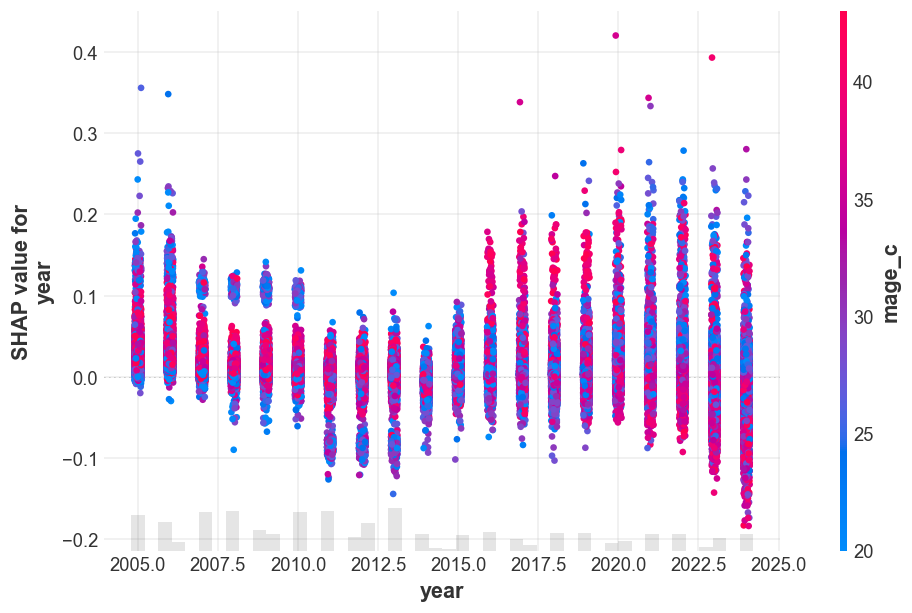

<Figure size 492x348 with 0 Axes>

In [25]:
ax = shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
# ax.set_title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 1


In [26]:
features_to_remove_0 = [
    "pwgt_r",
    "rf_ghype",
    "rf_gdiab",
    "ab_seiz",
    "feduc",
    "rf_phype",
    "sex",
    "rf_pdiab",
    "ab_surf",
    "ld_augm",
    "rf_ehype",
    "rf_inftr",
    "pay_rec",
    "no_risks",
    "rf_artec",
    "rf_fedrg",
    "dob_tt_pm",
    "rf_ppterm",
    "wic",
    "apgar10",
]

X_train = X_train.drop(columns=features_to_remove_0)
X_valid = X_valid.drop(columns=features_to_remove_0)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_0]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 1
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_0)} predictors)"
)

print(f"Features removed: {features_to_remove_0}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

Features removed: ['pwgt_r', 'rf_ghype', 'rf_gdiab', 'ab_seiz', 'feduc', 'rf_phype', 'sex', 'rf_pdiab', 'ab_surf', 'ld_augm', 'rf_ehype', 'rf_inftr', 'pay_rec', 'no_risks', 'rf_artec', 'rf_fedrg', 'dob_tt_pm', 'rf_ppterm', 'wic', 'apgar10']
Features remaining: ['dob_mm', 'dob_wk', 'bfacil3', 'precare', 'gestrec10', 'ld_indl', 'me_pres', 'dmeth_rec', 'apgar5', 'ab_aven1', 'ab_aven6', 'ab_nicu', 'ab_anti', 'no_abnorm', 'ca_anen', 'ca_mnsb', 'ca_cchd', 'ca_cdh', 'ca_omph', 'ca_gast', 'ca_limb', 'ca_cleft', 'ca_clpal', 'ca_hypo', 'ca_disor', 'no_congen', 'meduc', 'mracehisp', 'fracehisp', 'year', 'dbwt', 'wtgain', 'bmi', 'mage_c', 'fagecomb']
Number of features in Model 1 (after removing 20 predictors): 35


In [ ]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

In [ ]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [ ]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

In [ ]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

In [ ]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [ ]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

In [ ]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [ ]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

In [ ]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

In [ ]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

In [ ]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [ ]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

In [ ]:
shap_importance["feature"].tolist()

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

In [ ]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
plt.title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 2


In [ ]:
features_to_remove_1 = [
    "wtgain",  # correlated with bmi
    "fracehisp",  # low SHAP value, correlated with mracehisp
    "bmi",  # low SHAP value
    "meduc",  # low SHAP value
    "dob_wk",  # low SHAP value
    "dmeth_rec",  # low SHAP value
    "bfacil3",  # low SHAP value
    "rf_ghype",  # low SHAP value
    "ca_omph",  # low SHAP value
    "pay_rec",  # low SHAP value
    "apgar5",  # low SHAP value
    "rf_ehype",  # low SHAP value
]

X_train = X_train.drop(columns=features_to_remove_1)
X_valid = X_valid.drop(columns=features_to_remove_1)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_1]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 2
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_1)} predictors)"
)

print(f"Features removed: {features_to_remove_1}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

In [ ]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

In [ ]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [ ]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

In [ ]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

In [ ]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [ ]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

In [ ]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [ ]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

In [ ]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

In [ ]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

In [ ]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [ ]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

In [ ]:
shap_importance["feature"].tolist()

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

In [ ]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
plt.title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 3


## Calibration


In [ ]:
p_cal_raw = gbm.predict(X_cal, num_iteration=gbm.best_iteration, raw_score=True)

In [ ]:
calibrator = LogisticRegression(solver="lbfgs", max_iter=1000)
calibrator.fit(p_cal_raw.reshape(-1, 1), y_cal)

In [ ]:
def predict_proba_calibrated(gbm, calibrator, X_new, num_iteration=None):
    p_raw = gbm.predict(X_new, num_iteration=num_iteration, raw_score=True)
    return calibrator.predict_proba(p_raw.reshape(-1, 1))[:, 1]

## Prediction


In [ ]:
p_valid_cal = predict_proba_calibrated(
    gbm, calibrator, X_valid, num_iteration=gbm.best_iteration
)
p_valid_raw = gbm.predict(X_valid, num_iteration=gbm.best_iteration)

print("Raw logloss:", log_loss(y_valid, p_valid_raw, labels=[0, 1]))
print("Cal logloss:", log_loss(y_valid, p_valid_cal, labels=[0, 1]))
print("Raw brier:  ", brier_score_loss(y_valid, p_valid_raw))
print("Cal brier:  ", brier_score_loss(y_valid, p_valid_cal))